# Validation of a Python Solar Wind Speed Calculator
This notebook validates a Python implementation of the Doppler Dimming Technique for calculating solar wind speed maps in the solar corona.

The results from the Python code are compared directly against solar wind speed maps produced by the IDL version of the algorithm, which serves as the validation benchmark. 

The ultraviolet (UV) and electron density ($N_e$), available in the folder 'data_benchmark' data are derived from the [Metis](https://metis.oato.inaf.it/index.html) coronagraph onboard the [Solar Orbiter](https://www.esa.int/Science_Exploration/Space_Science/Solar_Orbiter) spacecraft.

- Author: Dario Vetrano
- Date: August 2025
- Contact: dario.vetrano@studenti.polito.it
---

### Project Overview

This notebook contains a Python implementation for deriving 2D solar wind outflow velocity maps from coronagraphic observations using the Doppler Dimming Technique (DDT). The primary objective is to synthesize the resonantly scattered H I Ly-α line intensity and iteratively match it with observational data to map plasma outflow speeds in the inner heliosphere.

### References

This work is based on the methods and models described in the following publications:

* Giordano, S., et al. (2025), *Solar wind speed maps from the Metis coronagraph observations*
* Dolei, S., et al. (2019), *Effect of the non-uniform solar chromospheric Lya radiation on determining the coronal HI outflow velocity*
* Dolei, S., et al. (2018), *Mapping the solar wind HI outflow velocity in the inner heliosphere*
* Auchère, F. (2005), *Effect of the H I Lyα Chromospheric Flux Anisotropy on the Total Intensity of the Resonantly Scattered Coronal Radiation*
* Gibson, S. E., et al. (1999), *Solar minimum streamer densities and temperatures using Whole Sun Month coordinated data sets*

#### Importing libraries and environment setup

In [1]:
# =============================================================================
#  1. CORE LIBRARIES 
# =============================================================================
import os
import sys
import platform
import time
import warnings
from pathlib import Path
from os.path import basename

sys.path.append(str(Path().resolve().parent.parent))

# =============================================================================
#  2. SCIENTIFIC COMPUTING LIBRARIES
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16

import matplotlib.ticker as ticker
from matplotlib import cm
from scipy.optimize import brentq, curve_fit, least_squares, newton
from scipy.interpolate import interp1d
from scipy import ndimage

# =============================================================================
#  3. ASTRONOMY & ASTROPHYSICS LIBRARIES
# =============================================================================
import astropy.units as u
from astropy.io import fits
from astropy.wcs import FITSFixedWarning, WCS
from astropy.io.fits.verify import VerifyWarning
import sunpy.map
from sunpy.sun import constants

# --- CHIANTI Atomic Database Setup ---
# ChiantiPy requires the $XUVTOP environment variable to point to the database location.
# This section sets the path programmatically.

# First, ensure the HOME variable is set, which is sometimes needed for Windows users
if 'HOME' not in os.environ and platform.system() == 'Windows':
    os.environ['HOME'] = os.path.expanduser('~')

# !!! IMPORTANT !!!
# You must replace the path below with the location of the CHIANTI database on your computer.
# xuvtop_path = r'C:\PATH\TO\YOUR\CHIANTI_11.0.2_database'
xuvtop_path = r'C:\Users\Lenovo1\Desktop\CORONA HYDRODYNAMIC STABILITY\Doppler Dimming Technique\codice\CHIANTI_DB\CHIANTI_11.0.2_database' 
os.environ['XUVTOP'] = xuvtop_path

import ChiantiPy.core as ch

# =============================================================================
#  4. LOCAL MODULES & CUSTOM FUNCTIONS
# =============================================================================
from src.aux_lib_lyman_alpha import compute_velocity_maps
from src.metis_aux_lib import calc_el_dens_and_K, polar_to_cart, align_polar_maps, fit_negative_power_series, cut_metis_fov, cart_to_polar, sqrt_model, extract_datetime_from_filename

# =============================================================================
#  5. ENVIRONMENT CONFIGURATION
# =============================================================================
# Suppress a common, often benign, warning from Astropy when reading FITS headers
warnings.filterwarnings('ignore', category=FITSFixedWarning)
warnings.simplefilter('ignore', category=VerifyWarning)

# =============================================================================
#  6. JUPYTER MAGIC COMMANDS
# =============================================================================
%reload_ext autoreload
%autoreload 2

c:\ProgramData\miniforge3\envs\doppler310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ChiantiPy version 0.15.2 
 found PyQt5 widgets
 using PyQt5 widgets


#### Load the Metis UV data

In [2]:
path_uv = Path(r"./data_benchmark/input/solo_L2_metis-uv-20210114T004530-cmb_0.85_1.fts")

fits_uv = fits.open(path_uv)[0] 

fits_uv.header['RSUN_OBS'] = fits_uv.header['RSUN_ARC']
date_UV = fits_uv.header.get("DATE_OBS") 

map_uv = sunpy.map.Map(fits_uv.data, fits_uv.header)

cut_metis_fov(fits_uv)

METIS_UV_CMAP = plt.colormaps["RdYlBu_r"].copy()
METIS_UV_CMAP.set_bad(color='tab:gray')

#### Coordinate transformation and visual representation of the UV maps

In [6]:
polar_uv, r_matrix_uv_pix, r_arr_uv, rsun_pix_uv, phi_arr_uv = cart_to_polar(fits_uv, dr = 1, dphi = 1, rot_angle=None, cval=np.nan, cut_out_fov = 50, cut_in_fov = 0)

r_matrix_uv = r_matrix_uv_pix / rsun_pix_uv
r_arr_uv = r_arr_uv / rsun_pix_uv

wcs_uv = WCS(fits_uv.header)

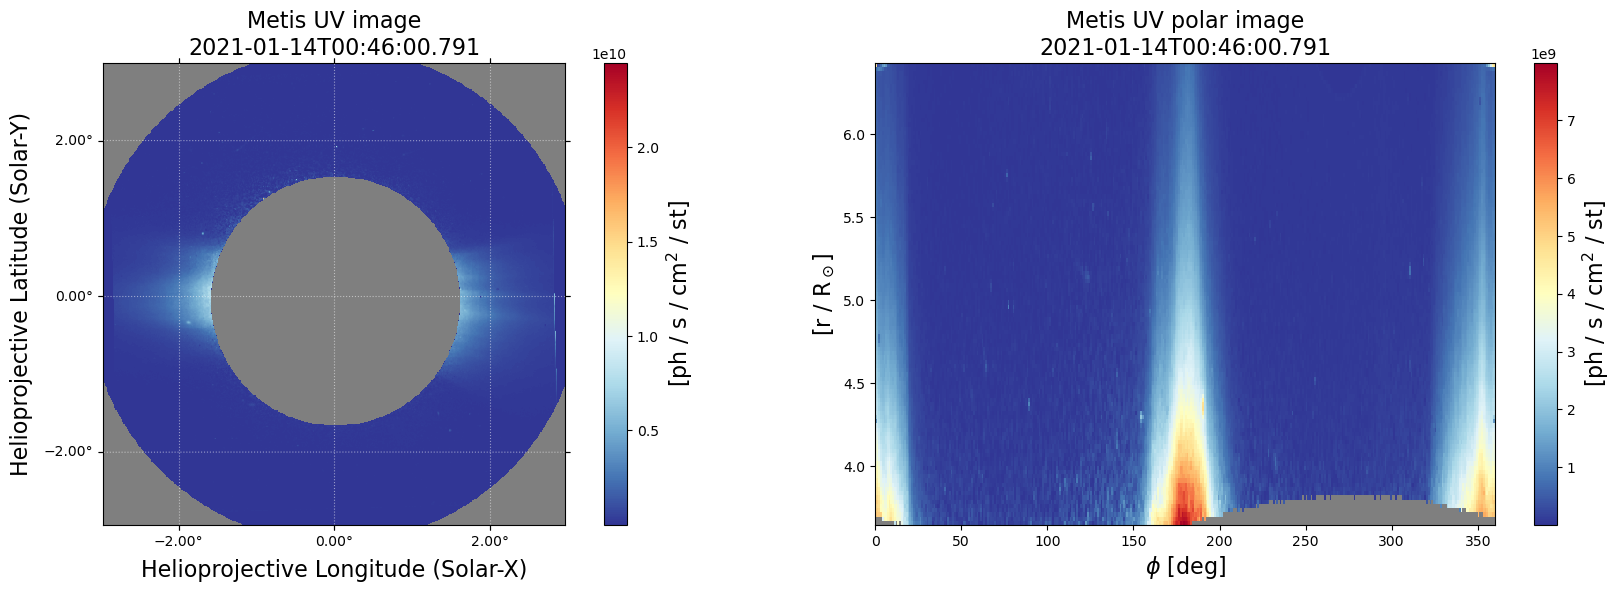

In [7]:
# PLOT
fig = plt.figure(figsize=(22, 6))

ax0 = fig.add_subplot(1, 2, 1, projection=wcs_uv)

img_uv = ax0.imshow(fits_uv.data, origin='lower', cmap=METIS_UV_CMAP, interpolation='none')
cbar_uv = plt.colorbar(img_uv, ax=ax0, label= '[ph / s / cm$^2$ / st]')

lon, lat = ax0.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax0.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax0.set_xlabel('Helioprojective Longitude (Solar-X)')
ax0.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax0.set_title('Metis UV image\n' + date_UV)


ax1 = fig.add_subplot(1, 2, 2)  
img_uv_pol = ax1.imshow(polar_uv, origin='lower', cmap=METIS_UV_CMAP, interpolation='none',  extent=[0, polar_uv.shape[1], r_arr_uv[0], r_arr_uv[-1]], aspect = 'auto')
ax1.set_ylabel("[r / R$_\\odot$]")
ax1.set_xlabel("$\phi$ [deg]")
cbar_uv_pol = plt.colorbar(img_uv_pol, ax=ax1, label='[ph / s / cm$^2$ / st]')
ax1.set_title('Metis UV polar image\n' + date_UV);

#### Load the Electron Density ($N_e$) maps

In [8]:
path_ne = Path("./data_benchmark/input/solo_L2_metis-vl-pb_20210114T003001_V01_1_0.71_ne.fts")

fits_ne = fits.open(path_ne)[0]

date_ne = fits_ne.header.get("DATE_OBS") 

cut_metis_fov(fits_ne)

METIS_NE_CMAP = plt.colormaps["plasma"].copy()
METIS_NE_CMAP.set_bad(color='tab:gray') 

#### Coordinate transformation and visual representation of the $N_e$ maps

In [9]:
polar_ne, r_matrix_ne_pix, r_arr_ne, rsun_pix_ne, phi_arr_ne = cart_to_polar(fits_ne, dr = 1, dphi = 1, cval=np.nan, cut_out_fov = 0, cut_in_fov = 5)

r_matrix_ne = r_matrix_ne_pix / rsun_pix_ne
r_arr_ne = r_arr_ne / rsun_pix_ne

wcs_ne = WCS(fits_ne.header)

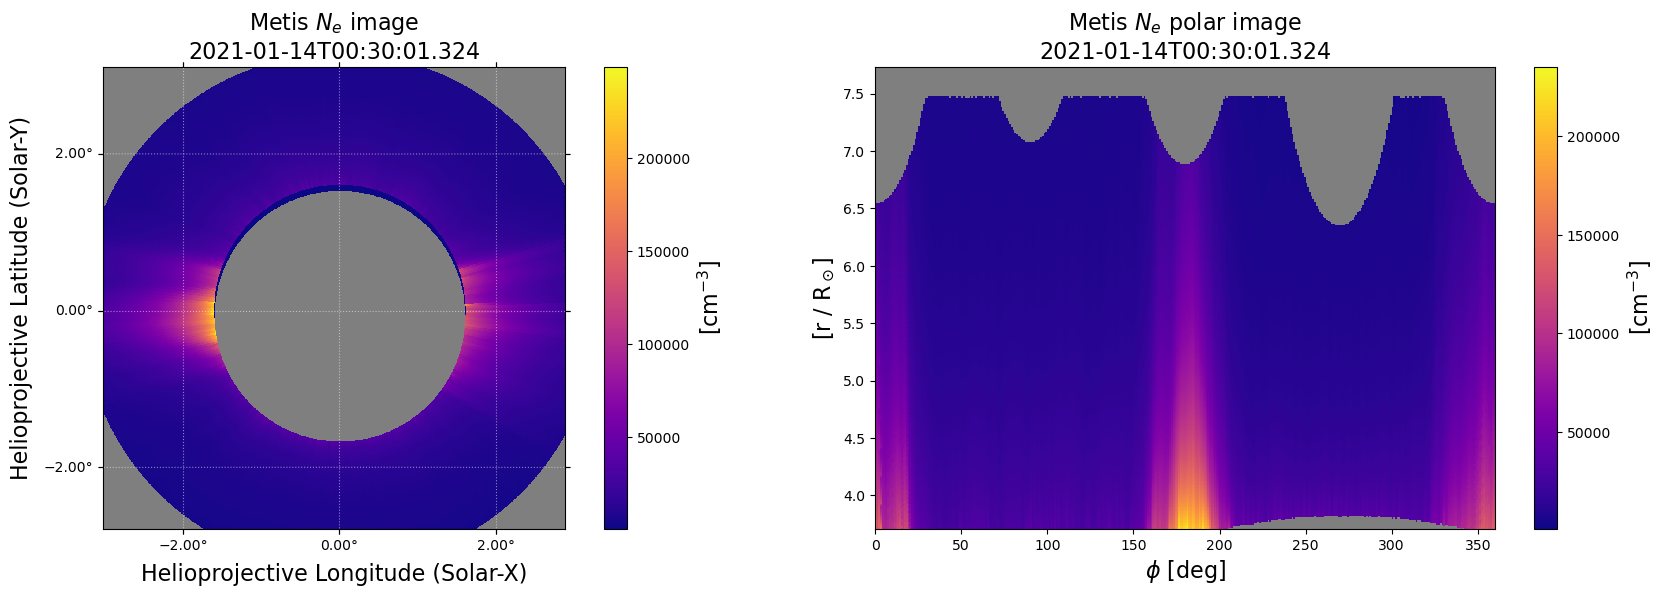

In [10]:
# PLOT
fig = plt.figure(figsize=(22, 6))

ax0 = fig.add_subplot(1, 2, 1, projection=wcs_ne)

img_ne = ax0.imshow(fits_ne.data, origin='lower', cmap=METIS_NE_CMAP, interpolation='none')
cbar_ne = plt.colorbar(img_ne, ax=ax0, label='[cm$^{-3}$]')

lon, lat = ax0.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax0.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax0.set_xlabel('Helioprojective Longitude (Solar-X)')
ax0.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax0.set_title('Metis $N_e$ image\n' + date_ne)

ax1 = fig.add_subplot(1, 2, 2)  
img_ne_pol = ax1.imshow(polar_ne, origin='lower', cmap=METIS_NE_CMAP, interpolation='none',  extent=[0, polar_ne.shape[1], r_arr_ne[0], r_arr_ne[-1]], aspect = 'auto')
ax1.set_ylabel("[r / R$_\\odot$]")
ax1.set_xlabel("$\phi$ [deg]")
# ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
cbar_uv_pol = plt.colorbar(img_ne_pol, ax=ax1, label='[cm$^{-3}$]')
ax1.set_title('Metis $N_e$ polar image\n' + date_ne);

## Pre-processing of the Polar Maps (UV and $N_e$)

To allow for a direct, pixel-by-pixel comparison, the UV and $N_e$ polar maps must have the same shape to ensure they are perfectly overlapping.
By convention, we resample the UV map to match the $N_e$ map. A final mask is the applied to keep only the pixels where both maps have non-NaN values.

Visual representation of the various arrays (and matrices) defined inside the function align_polar_maps:

![geometry_overlap_visual](geometry_overlap_visual.png)




In [11]:
polar_uv_resam, polar_ne_resam, r_matrix, r_common = align_polar_maps(polar_uv, r_matrix_uv, r_arr_uv, polar_ne, r_matrix_ne, r_arr_ne)

--- Aligning Polar Maps ---
Original A shape: (109, 360), Original B shape: (315, 360)
Resampled A shape: (212, 360), Resampled B shape: (212, 360)
New common grid created with 212 radial steps from 3.71 R☉ to 6.43 R☉.
--- Alignment Complete ---


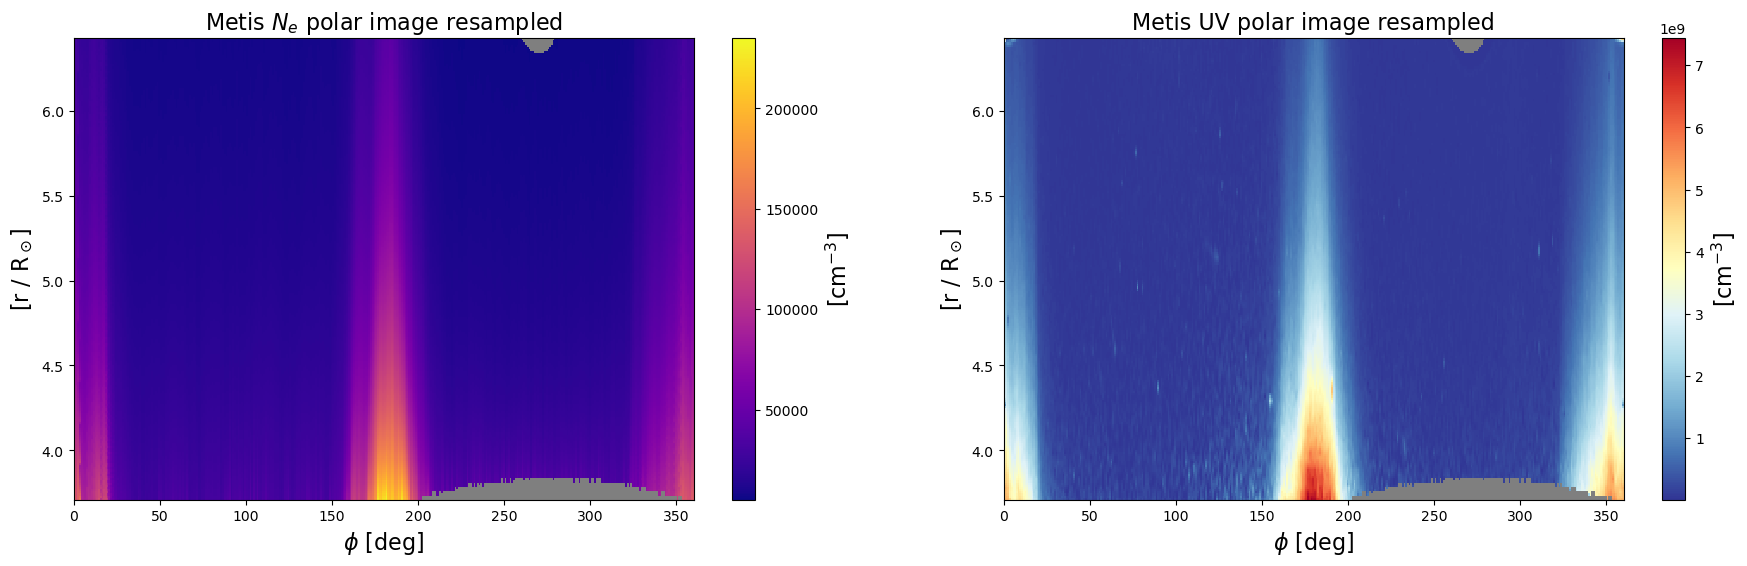

In [12]:
# PLOT
fig = plt.figure(figsize=(22, 6))

ax1 = fig.add_subplot(1, 2, 1)  
img_ne_pol = ax1.imshow(polar_ne_resam, origin='lower', cmap=METIS_NE_CMAP, interpolation='none', extent=[0, polar_ne_resam.shape[1], r_common[0], r_common[-1] ], aspect = 'auto')
ax1.set_ylabel("[r / R$_\\odot$]")
ax1.set_xlabel("$\phi$ [deg]")
cbar_uv_pol = plt.colorbar(img_ne_pol, ax=ax1, label='[cm$^{-3}$]')
ax1.set_title('Metis $N_e$ polar image resampled');

ax2 = fig.add_subplot(1, 2, 2)  
img_uv_pol = ax2.imshow(polar_uv_resam, origin='lower', cmap=METIS_UV_CMAP, interpolation='none', extent=[0, polar_uv_resam.shape[1], r_common[0] , r_common[-1] ], aspect = 'auto')
ax2.set_ylabel("[r / R$_\\odot$]")
ax2.set_xlabel("$\phi$ [deg]")
cbar_ne_pol = plt.colorbar(img_uv_pol, ax=ax2, label='[cm$^{-3}$]')
ax2.set_title('Metis UV polar image resampled');

### End of the preprocessing section
# Calculating the Solar Wind Velocity Map 
#### Step I: $V_w = $ const. along LOS
#### Step II: $V_w = f(x_{\text{LOS}})$
The core of the analysis is to determine the Solar Wind speed for each pixel in the pre-processed polar maps (UV and $N_e$): this is achieved through the definition of a resonant scattering model, and iteratively solving for the velocity that reproduces the observed UV intensity.

The algorithm iterates through every valid pixel, defined by its radius $r \in [\text{IN\_FOV}, \text{OUT\_FOV}]$ and polar angle $\phi \in [\phi_{\text{ROI,min}}, \phi_{\text{ROI,max}}]$.

In [45]:
angle_ROI = np.r_[0:360]

velocity_map_kms_I, velocity_map_kms_II = compute_velocity_maps(
    polar_ne_resam=polar_ne_resam,
    polar_uv_resam=polar_uv_resam,
    r_matrix=r_matrix,
    angle_ROI=angle_ROI,
    save_matrix=True,
    date=str(date_UV + "_shift"),
    save_path = "python_data_output"
)

# velocity_map_kms_I = np.load("python_data_output/vw_map_step_1_vv_2.01_scale.npy")
# velocity_map_kms_II = np.load("python_data_output/vw_map_step_2_vv_2.01_scale.npy")

Step II: angles: 100%|██████████| 360/360 [06:35<00:00,  1.10s/it]

Velocity maps saved.


#### Load the benchmark velocity map, apply coordinate transformation, and visualize


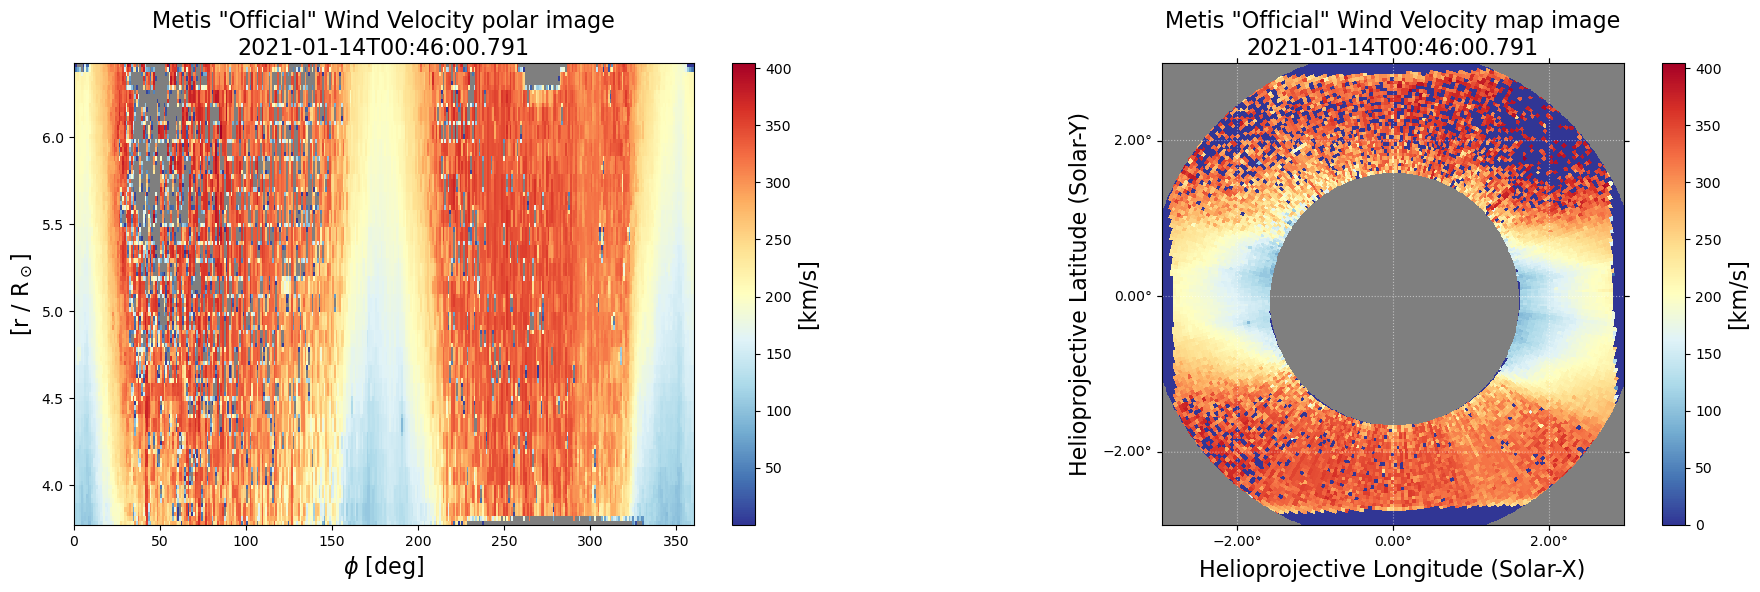

In [46]:
path_Vw = Path(r"./data_benchmark/output/ddt_ws_20210114T004530_Gi_10_100_1.fts")

fits_Vw = fits.open(path_Vw)[0]

fits_Vw.header = fits_uv.header
fits_Vw.data = fits_Vw.data / 1e5

date_off_Vw = fits_Vw.header.get("DATE_OBS") 

cut_metis_fov(fits_Vw)

polar_Vw, r_matrix_Vw, r_arr_Vw, rsun_pix_Vw, phi_arr_Vw = cart_to_polar(fits_Vw, cval=np.nan, cut_out_fov = 50, cut_in_fov = 5)

polar_Vw[polar_Vw == 0.0] = np.nan

r_arr_Vw /= rsun_pix_Vw # [pix] → [R☉]

wcs_Vw = WCS(fits_Vw.header)

fig = plt.figure(figsize=(22, 6))

ax0 = fig.add_subplot(1, 2, 1)  
img_Vw_pol = ax0.imshow(polar_Vw, origin='lower', cmap=METIS_UV_CMAP, interpolation='none',  extent=[0, polar_ne.shape[1], r_arr_Vw[0], r_arr_Vw[-1]], aspect = 'auto')
ax0.set_ylabel("[r / R$_\\odot$]")
ax0.set_xlabel("$\phi$ [deg]");
cbar_Vw_pol = plt.colorbar(img_Vw_pol, ax=ax0, label='[km/s]')
ax0.set_title('Metis "Official" Wind Velocity polar image\n' + date_off_Vw);

# WCS image
ax1 = fig.add_subplot(1, 2, 2, projection=wcs_Vw)

img_Vw = ax1.imshow(fits_Vw.data, origin='lower', cmap=METIS_UV_CMAP, interpolation='none')
cbar_Vw = plt.colorbar(img_Vw, ax=ax1, label='[km/s]')

lon, lat = ax1.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax1.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax1.set_xlabel('Helioprojective Longitude (Solar-X)')
ax1.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax1.set_title('Metis "Official" Wind Velocity map image\n' + date_off_Vw);

#### Post-processing of the computed Solar Wind speed map and comparison with the benchmark map

In [47]:
my_cartesian_Vw_I = polar_to_cart(velocity_map_kms_I, (1024, 1024), 512, 512, rsun_pix_ne, r_common[0], r_common[-1], 1 / rsun_pix_ne, rot_angle=None, cut_fov=True)

my_cartesian_Vw_II = polar_to_cart(velocity_map_kms_II, (1024, 1024), 512, 512, rsun_pix_ne, r_common[0], r_common[-1], 1 / rsun_pix_ne, rot_angle=None, cut_fov=True)


my_Vw_map_resam_I, official_Vw_map_resam, r_matrix_common_Vw, r_common_Vw = align_polar_maps(velocity_map_kms_I, r_matrix, r_common, polar_Vw, r_matrix_Vw / rsun_pix_Vw, r_arr_Vw)
my_Vw_map_resam_II, _, _, _ = align_polar_maps(velocity_map_kms_II, r_matrix, r_common, polar_Vw, r_matrix_Vw / rsun_pix_Vw, r_arr_Vw)

--- Aligning Polar Maps ---
Original A shape: (212, 360), Original B shape: (104, 360)
Resampled A shape: (206, 360), Resampled B shape: (206, 360)
New common grid created with 206 radial steps from 3.77 R☉ to 6.43 R☉.
--- Alignment Complete ---
--- Aligning Polar Maps ---
Original A shape: (212, 360), Original B shape: (104, 360)
Resampled A shape: (206, 360), Resampled B shape: (206, 360)
New common grid created with 206 radial steps from 3.77 R☉ to 6.43 R☉.
--- Alignment Complete ---


#### Results plots for steps I and II

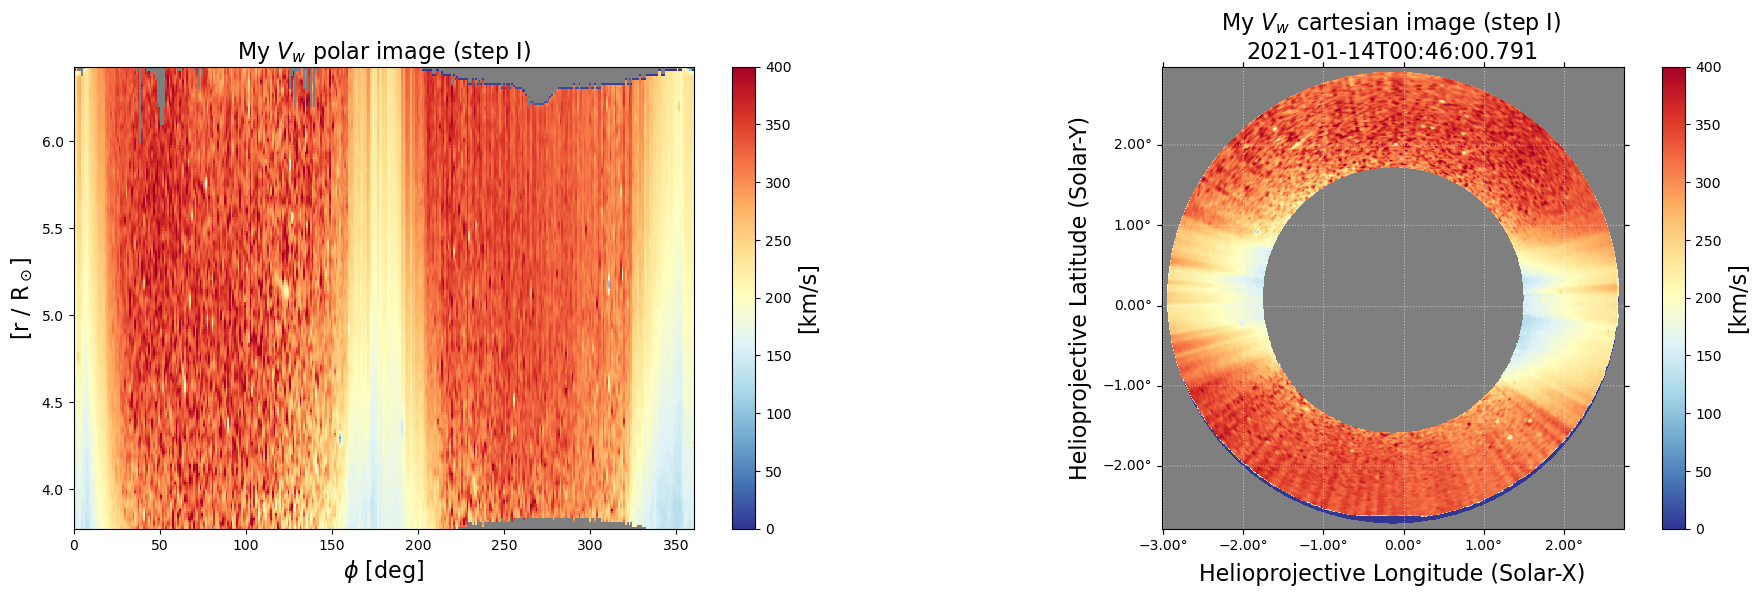

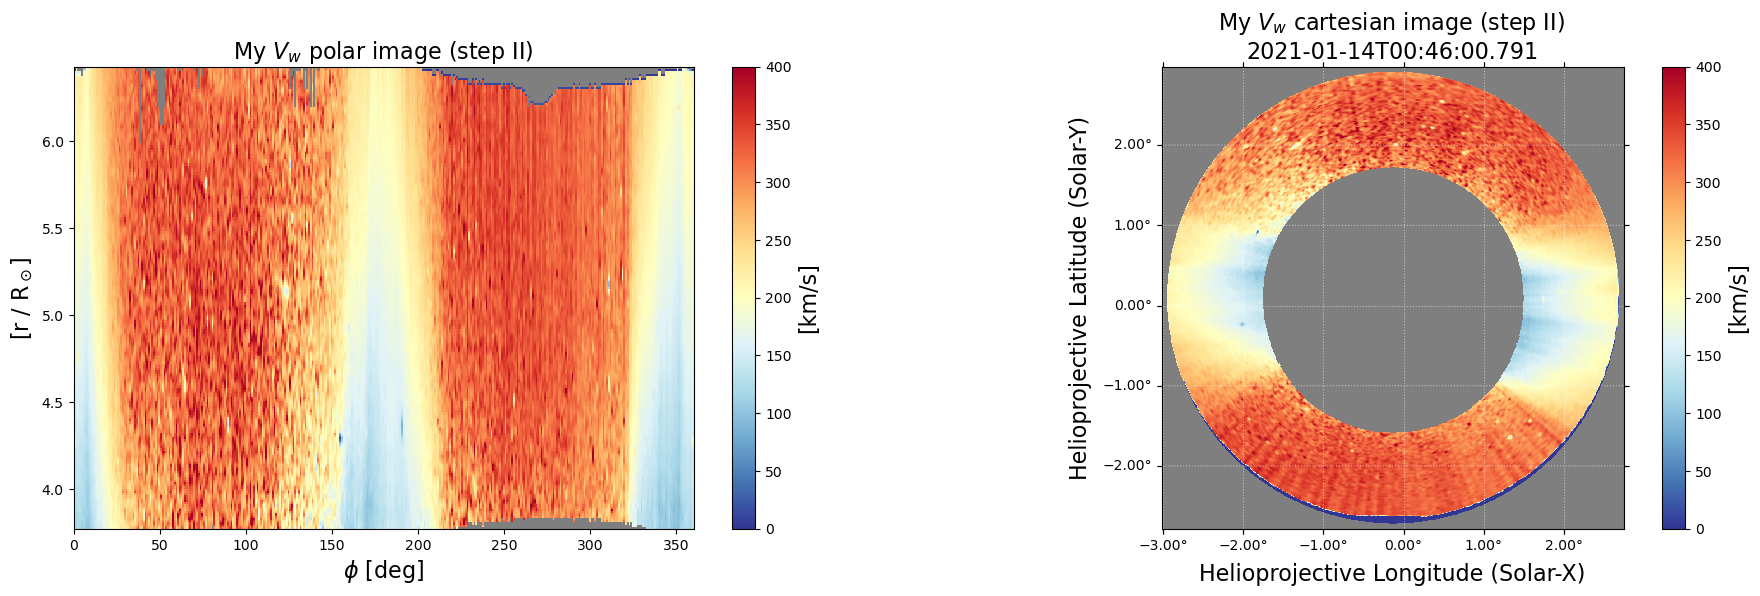

In [48]:
# PLOT

fig0 = plt.figure(figsize=(22, 6))

ax0 = fig0.add_subplot(1, 2, 1)  
img_Vw_pol0 = ax0.imshow(my_Vw_map_resam_I, origin='lower', cmap=METIS_UV_CMAP, interpolation='none',  vmin = 0, vmax = 400 , extent=[0, polar_ne.shape[1], r_arr_Vw[0] , r_arr_Vw[-1] ], aspect = 'auto')
ax0.set_ylabel("[r / R$_\\odot$]")
ax0.set_xlabel("$\phi$ [deg]");

my_cbar_Vw= plt.colorbar(img_Vw_pol0, ax=ax0, label='[km/s]')
ax0.set_title('My $V_w$ polar image (step I)');

ax1 = fig0.add_subplot(1, 2, 2, projection=wcs_ne)

img_Vw = ax1.imshow(my_cartesian_Vw_I, origin='lower', cmap=METIS_UV_CMAP,  vmin = 0, vmax = 400, interpolation='none')
cbar_Vw = plt.colorbar(img_Vw, ax=ax1, label='[km/s]')

lon, lat = ax1.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax1.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax1.set_xlabel('Helioprojective Longitude (Solar-X)')
ax1.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax1.set_title('My $V_w$ cartesian image (step I) \n' + date_off_Vw)

fig1 = plt.figure(figsize=(22, 6))

ax0 = fig1.add_subplot(1, 2, 1)  
img_Vw_pol1 = ax0.imshow(my_Vw_map_resam_II, origin='lower', cmap=METIS_UV_CMAP, interpolation='none',  vmin = 0, vmax = 400 , extent=[0, polar_ne.shape[1], r_arr_Vw[0] , r_arr_Vw[-1] ], aspect = 'auto')
ax0.set_ylabel("[r / R$_\\odot$]")
ax0.set_xlabel("$\phi$ [deg]");

my_cbar_Vw= plt.colorbar(img_Vw_pol1, ax=ax0, label='[km/s]')
ax0.set_title('My $V_w$ polar image (step II)');

ax1 = fig1.add_subplot(1, 2, 2, projection=wcs_ne)

img_Vw = ax1.imshow(my_cartesian_Vw_II, origin='lower', cmap=METIS_UV_CMAP,  vmin = 0, vmax = 400, interpolation='none')
cbar_Vw = plt.colorbar(img_Vw, ax=ax1, label='[km/s]')

lon, lat = ax1.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax1.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax1.set_xlabel('Helioprojective Longitude (Solar-X)')
ax1.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax1.set_title('My $V_w$ cartesian image (step II) \n' + date_off_Vw);

# Direct comparison between selected radials

#### Equatorial region - East: $\phi \in [0^\circ, 45^\circ] \cup [315^\circ, 360^\circ]$

Average value of the ratio ||official_Vw_map - my_Vw_map|| / my_Vw_map: 13.75 %


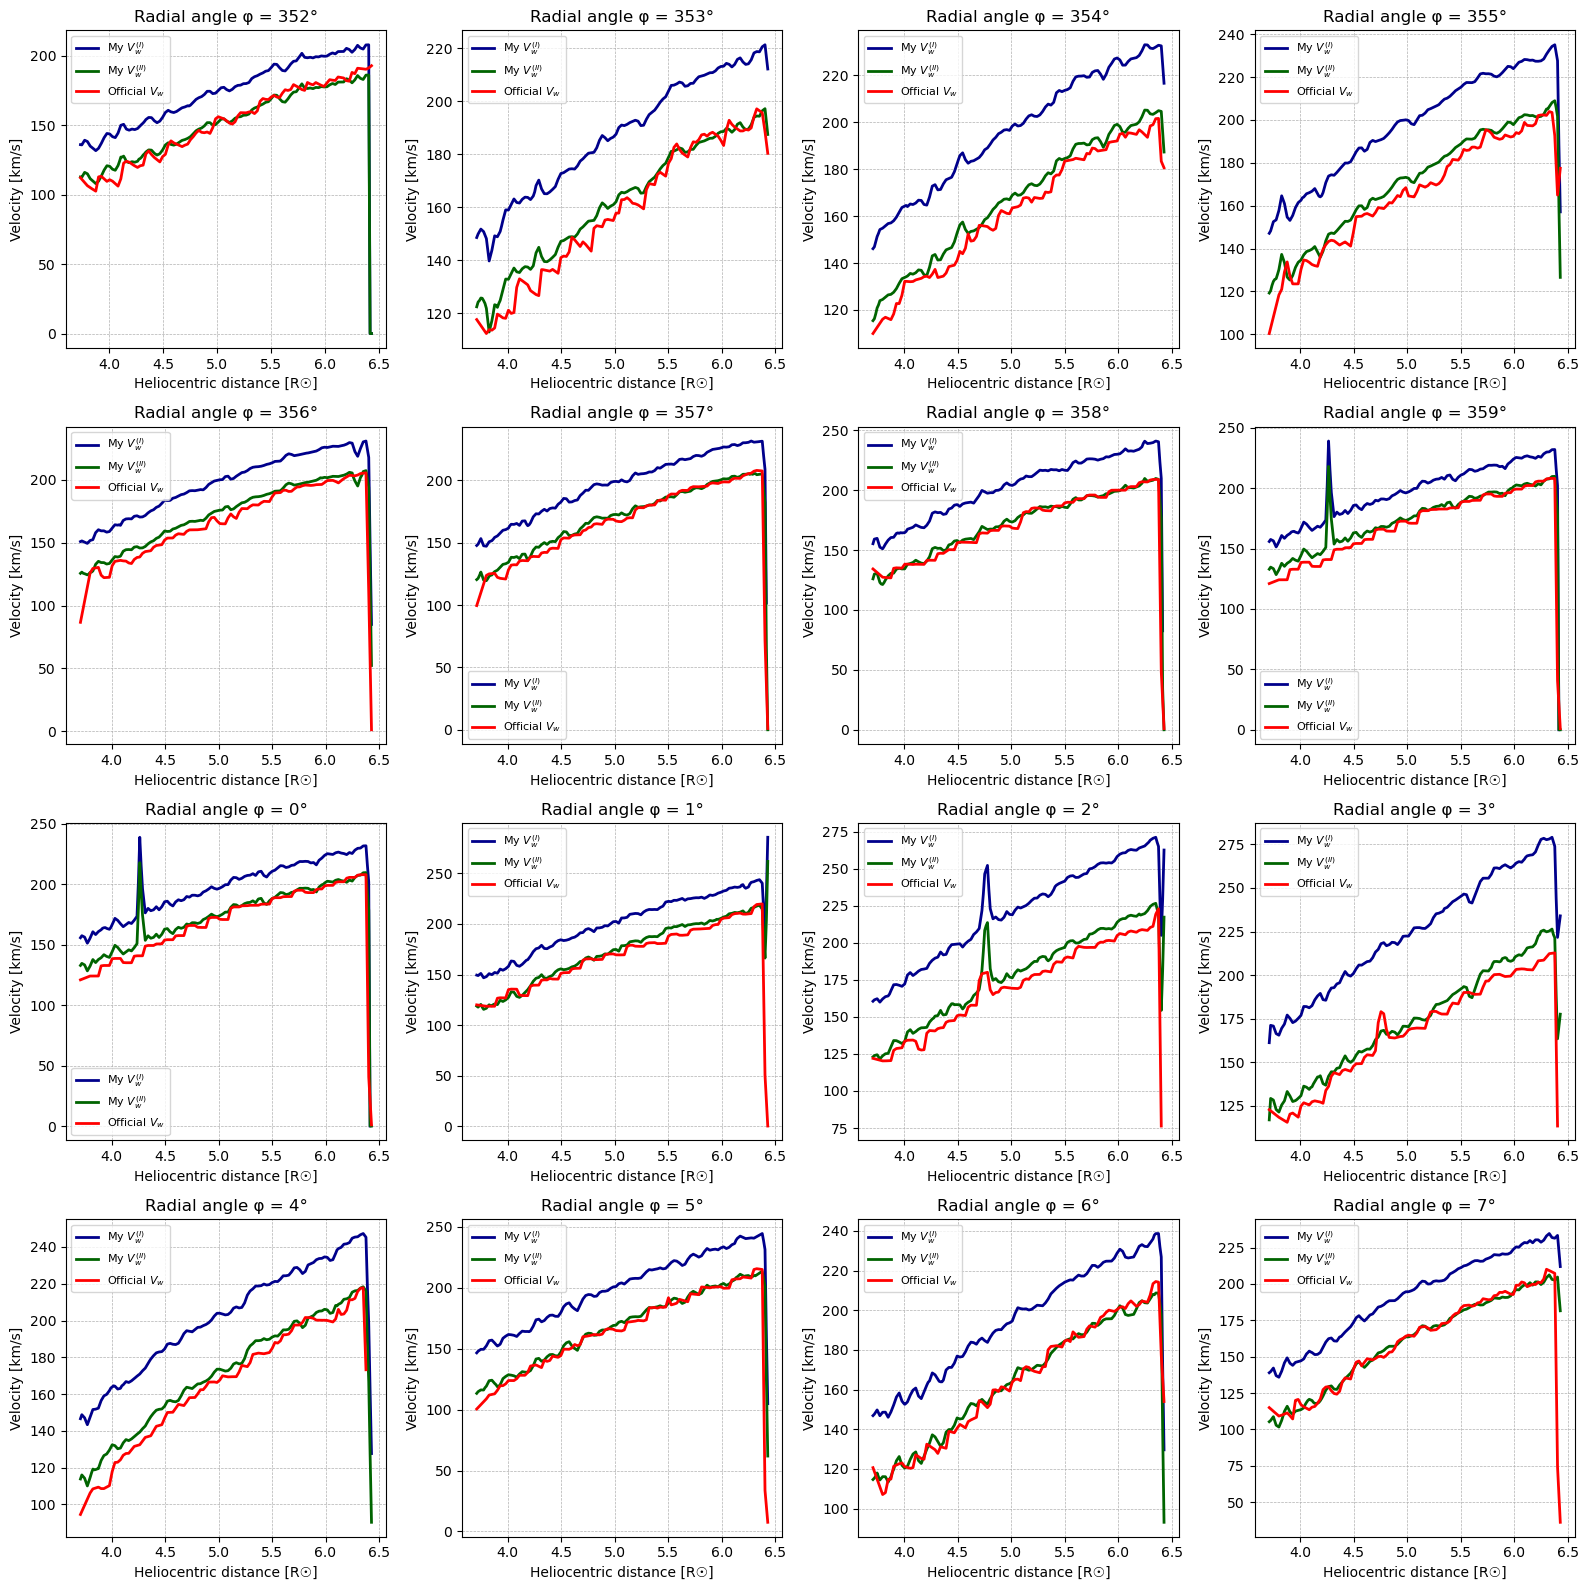

In [49]:
angle_ROI_plot = np.r_[352:360, 0:8]  

angle_ROI_mean = np.r_[0:45, 315:-1]

# Only the definition with my_Vw_map at the denominator is directly meaningful, as in the official_Vw_map the default value is zero (here it is NaN) 
print(f"Average value of the ratio ||official_Vw_map - my_Vw_map|| / my_Vw_map: {np.nanmean( np.abs(my_Vw_map_resam_II[:, angle_ROI_mean] - official_Vw_map_resam[:, angle_ROI_mean]) / my_Vw_map_resam_II[:, angle_ROI_mean]) * 100:.2f} %")

ncols = 4
nrows = round(np.ceil(len(angle_ROI_plot) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for ax, phi_select in zip(axes, angle_ROI_plot):
    r_radial = r_matrix[:, phi_select]
    v_radial_I = velocity_map_kms_I[:, phi_select]
    v_radial_II = velocity_map_kms_II[:, phi_select]

    r_radial_G = r_matrix_Vw[:, phi_select] / rsun_pix_Vw
    v_radial_G = polar_Vw[:, phi_select]

    interpolator_v = interp1d(r_radial_G, v_radial_G, kind='linear', fill_value="extrapolate")
    v_radial_G = interpolator_v(r_radial)
    
    ax.plot(r_radial, v_radial_I, color='darkblue', linewidth=2)
    ax.plot(r_radial, v_radial_II, color='darkgreen', linewidth=2)
    ax.plot(r_radial, v_radial_G, color='red', linewidth=2)
    
    ax.set_title(f"Radial angle φ = {phi_select}°", fontsize=12)
    ax.set_ylabel("Velocity [km/s]", fontsize=10)
    ax.set_xlabel("Heliocentric distance [R☉]", fontsize=10)
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    ax.legend(["My $V_w^{(I)}$", "My $V_w^{(II)}$", "Official $V_w$"], fontsize=8)

# Hide the last empty subplot (if any)
for ax in axes[len(angle_ROI_plot):]:
    ax.set_visible(False)

plt.tight_layout()

# plt.savefig('radial_cfr_btw_maps.png')
plt.show()


#### Polar region - North: $\phi \in [45^\circ, 135^\circ]$

Average value of the ratio ||official_Vw_map - my_Vw_map|| / my_Vw_map: 26.04 %


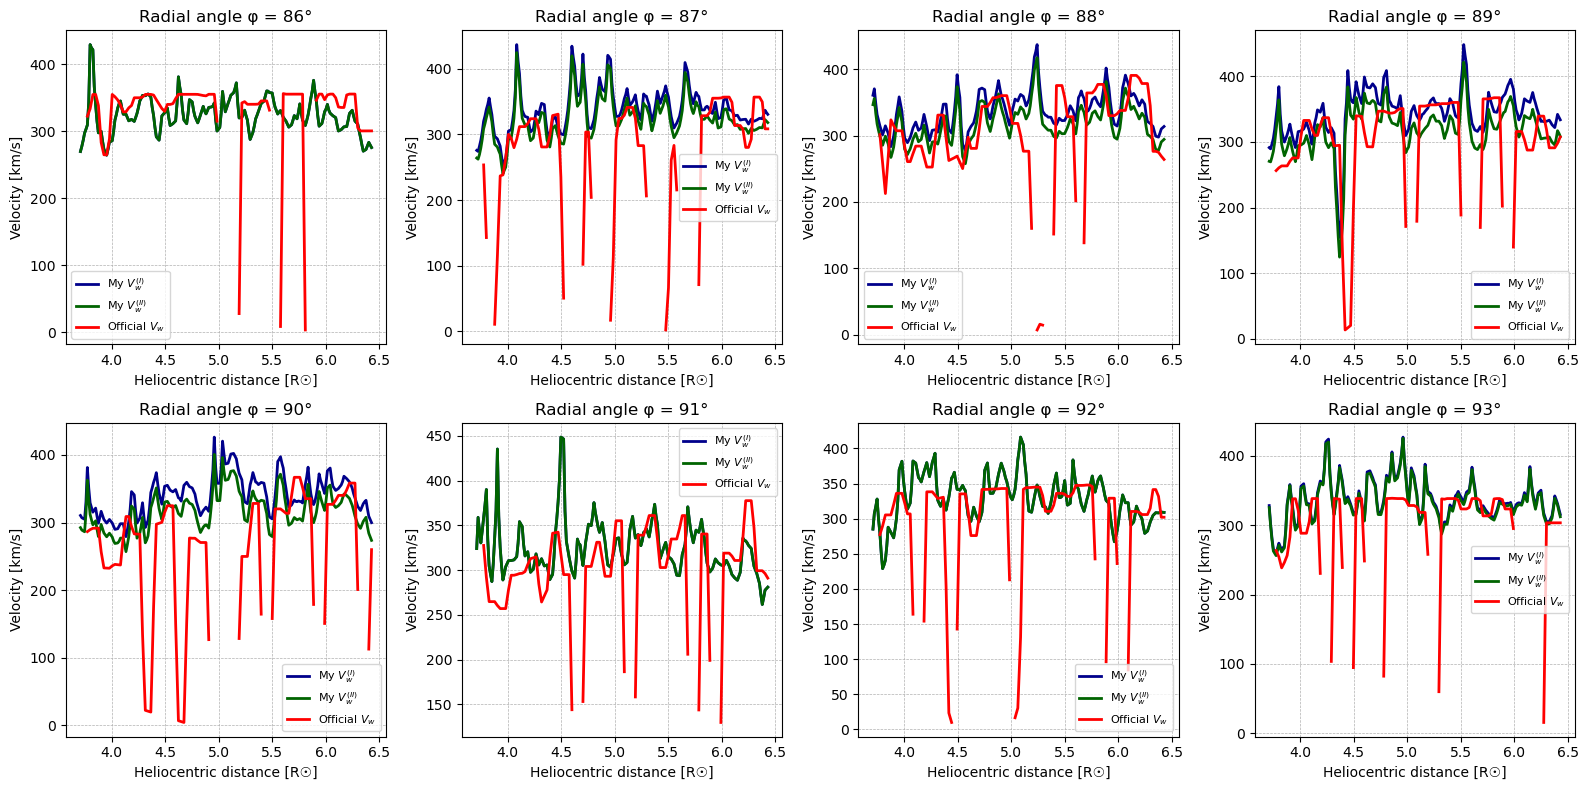

In [50]:
angle_ROI_plot = np.r_[86:94]

angle_ROI_mean = np.r_[45:135]

# Only the definition with my_Vw_map at the denominator is directly meaningful, as in the official_Vw_map the default value is zero (here it is NaN) 
print(f"Average value of the ratio ||official_Vw_map - my_Vw_map|| / my_Vw_map: {np.nanmean( np.abs(my_Vw_map_resam_II[:, angle_ROI_mean] - official_Vw_map_resam[:, angle_ROI_mean]) / my_Vw_map_resam_II[:, angle_ROI_mean]) * 100:.2f} %")

ncols = 4
nrows = round(np.ceil(len(angle_ROI_plot) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for ax, phi_select in zip(axes, angle_ROI_plot):
    r_radial = r_matrix[:, phi_select]
    v_radial_I = velocity_map_kms_I[:, phi_select]
    v_radial_II = velocity_map_kms_II[:, phi_select]

    r_radial_G = r_matrix_Vw[:, phi_select] / rsun_pix_Vw
    v_radial_G = polar_Vw[:, phi_select]

    interpolator_v = interp1d(r_radial_G, v_radial_G, kind='linear', fill_value="extrapolate")
    v_radial_G_new = interpolator_v(r_radial)
    
    ax.plot(r_radial, v_radial_I, color='darkblue', linewidth=2)
    ax.plot(r_radial, v_radial_II, color='darkgreen', linewidth=2)
    ax.plot(r_radial_G, v_radial_G, color='red', linewidth=2)
    ax.set_title(f"Radial angle φ = {phi_select}°", fontsize=12)
    ax.set_ylabel("Velocity [km/s]", fontsize=10)
    ax.set_xlabel("Heliocentric distance [R☉]", fontsize=10)
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    ax.legend(["My $V_w^{(I)}$", "My $V_w^{(II)}$", "Official $V_w$"], fontsize=8)

# Hide the last empty subplot (if any)
for ax in axes[len(angle_ROI_plot):]:
    ax.set_visible(False)

plt.tight_layout()

# plt.savefig('radial_cfr_btw_maps.png')
plt.show()


#### Equatorial region - West: $\phi \in [135^\circ, 225^\circ]$

Average value of the ratio ||official_Vw_map - my_Vw_map|| / my_Vw_map: 21.33 %


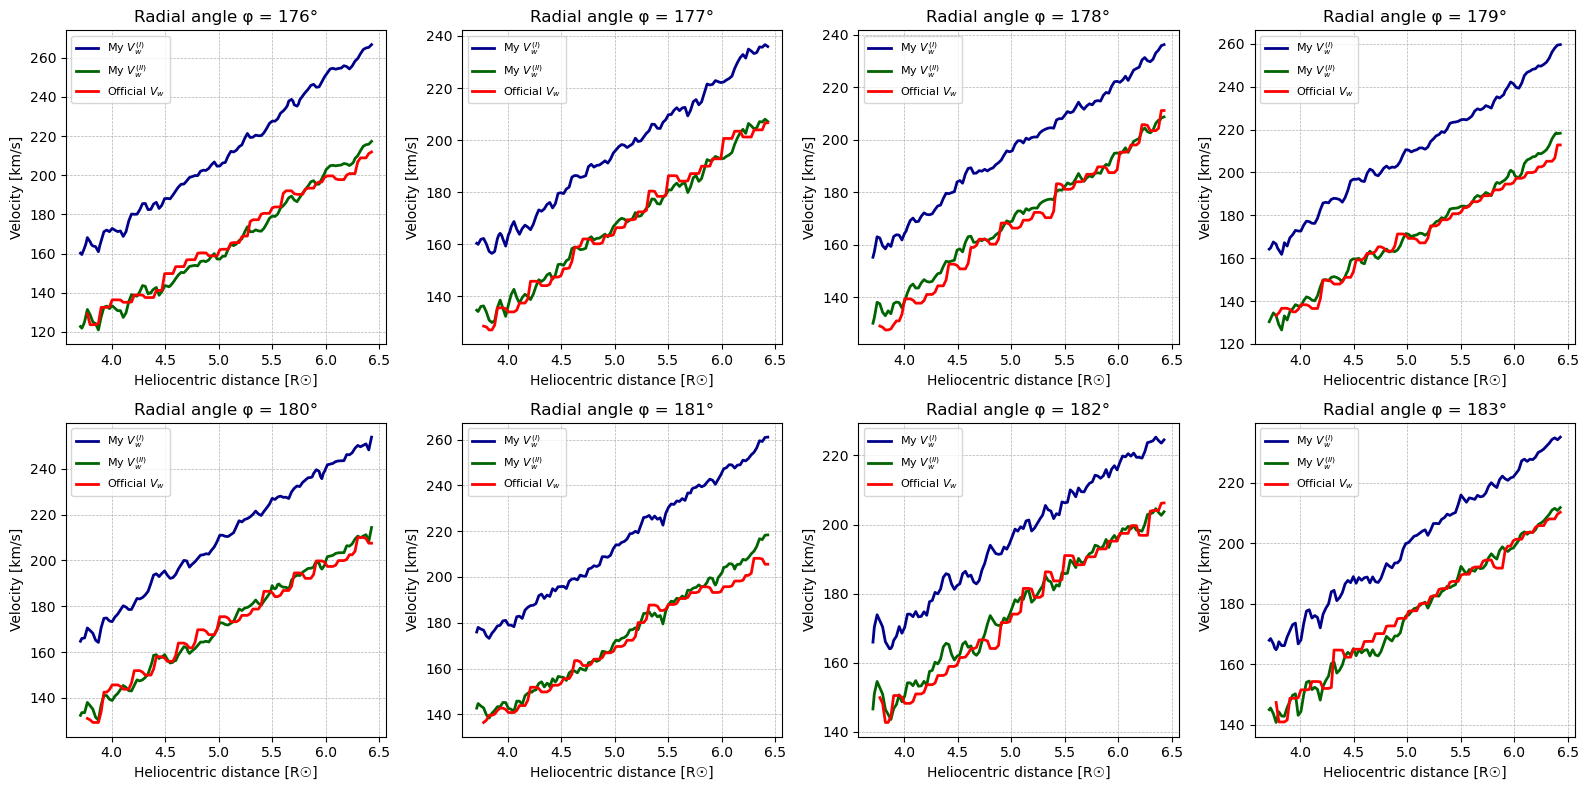

In [51]:
angle_ROI_plot = np.r_[176:184]

angle_ROI_mean = np.r_[135:225]

# Only the definition with my_Vw_map at the denominator is directly meaningful, as in the official_Vw_map the default value is zero (here it is NaN) 
print(f"Average value of the ratio ||official_Vw_map - my_Vw_map|| / my_Vw_map: {np.nanmean( np.abs(my_Vw_map_resam_II[:, angle_ROI_mean] - official_Vw_map_resam[:, angle_ROI_mean]) / my_Vw_map_resam_II[:, angle_ROI_mean]) * 100:.2f} %")

ncols = 4
nrows = round(np.ceil(len(angle_ROI_plot) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for ax, phi_select in zip(axes, angle_ROI_plot):
    r_radial = r_matrix[:, phi_select]
    v_radial_I = velocity_map_kms_I[:, phi_select]
    v_radial_II = velocity_map_kms_II[:, phi_select]

    r_radial_G = r_matrix_Vw[:, phi_select] / rsun_pix_Vw
    v_radial_G = polar_Vw[:, phi_select]

    interpolator_v = interp1d(r_radial_G, v_radial_G, kind='linear', fill_value="extrapolate")
    v_radial_G_new = interpolator_v(r_radial)
    
    ax.plot(r_radial, v_radial_I, color='darkblue', linewidth=2)
    ax.plot(r_radial, v_radial_II, color='darkgreen', linewidth=2)
    ax.plot(r_radial_G, v_radial_G, color='red', linewidth=2)
    ax.set_title(f"Radial angle φ = {phi_select}°", fontsize=12)
    ax.set_ylabel("Velocity [km/s]", fontsize=10)
    ax.set_xlabel("Heliocentric distance [R☉]", fontsize=10)
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    ax.legend(["My $V_w^{(I)}$", "My $V_w^{(II)}$", "Official $V_w$"], fontsize=8)

# Hide the last empty subplot (if any)
for ax in axes[len(angle_ROI_plot):]:
    ax.set_visible(False)

plt.tight_layout()

# plt.savefig('radial_cfr_btw_maps.png')
plt.show()


#### Polar region - South: $\phi \in [225^\circ, 315^\circ]$

Average value of the ratio ||official_Vw_map - my_Vw_map|| / my_Vw_map: 20.50 %


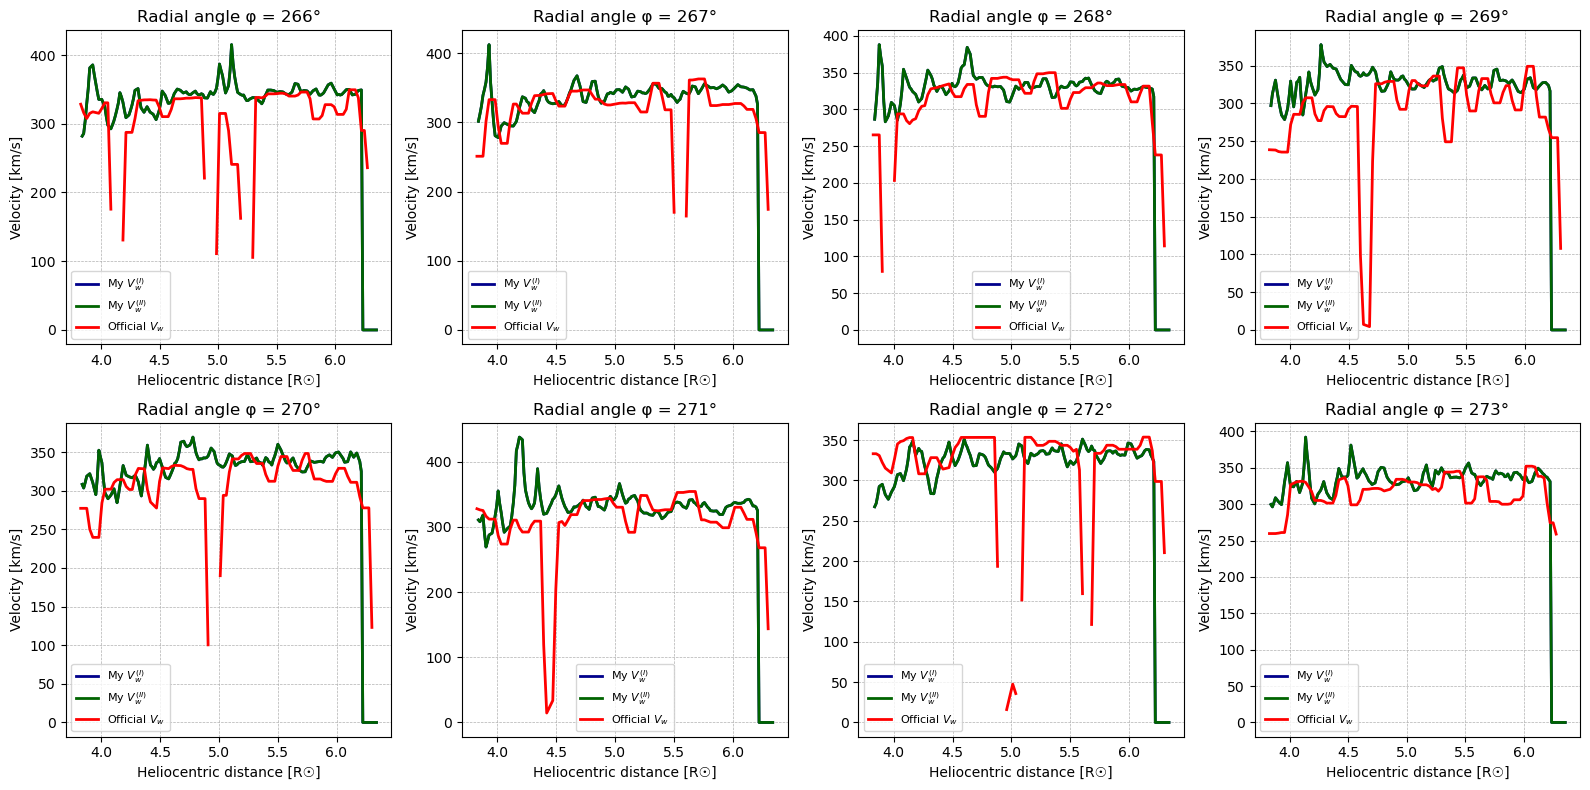

In [52]:
angle_ROI_plot = np.r_[266:274]

angle_ROI_mean = np.r_[225:315]

# Only the definition with my_Vw_map at the denominator is directly meaningful, as in the official_Vw_map the default value is zero (here it is NaN) 
print(f"Average value of the ratio ||official_Vw_map - my_Vw_map|| / my_Vw_map: {np.nanmean( np.abs(my_Vw_map_resam_II[:, angle_ROI_mean] - official_Vw_map_resam[:, angle_ROI_mean]) / my_Vw_map_resam_II[:, angle_ROI_mean]) * 100:.2f} %")

ncols = 4
nrows = round(np.ceil(len(angle_ROI_plot) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for ax, phi_select in zip(axes, angle_ROI_plot):
    r_radial = r_matrix[:, phi_select]
    v_radial_I = velocity_map_kms_I[:, phi_select]
    v_radial_II = velocity_map_kms_II[:, phi_select]

    r_radial_G = r_matrix_Vw[:, phi_select] / rsun_pix_Vw
    v_radial_G = polar_Vw[:, phi_select]

    interpolator_v = interp1d(r_radial_G, v_radial_G, kind='linear', fill_value="extrapolate")
    v_radial_G_new = interpolator_v(r_radial)
    
    ax.plot(r_radial, v_radial_I, color='darkblue', linewidth=2)
    ax.plot(r_radial, v_radial_II, color='darkgreen', linewidth=2)
    ax.plot(r_radial_G, v_radial_G, color='red', linewidth=2)
    ax.set_title(f"Radial angle φ = {phi_select}°", fontsize=12)
    ax.set_ylabel("Velocity [km/s]", fontsize=10)
    ax.set_xlabel("Heliocentric distance [R☉]", fontsize=10)
    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    ax.legend(["My $V_w^{(I)}$", "My $V_w^{(II)}$", "Official $V_w$"], fontsize=8)

# Hide the last empty subplot (if any)
for ax in axes[len(angle_ROI_plot):]:
    ax.set_visible(False)

plt.tight_layout()

# plt.savefig('radial_cfr_btw_maps.png')
plt.show()


# Overall comparison of the whole maps

Average value of the ratio map: 1.04
Average value of the difference map: 25.42 km/s


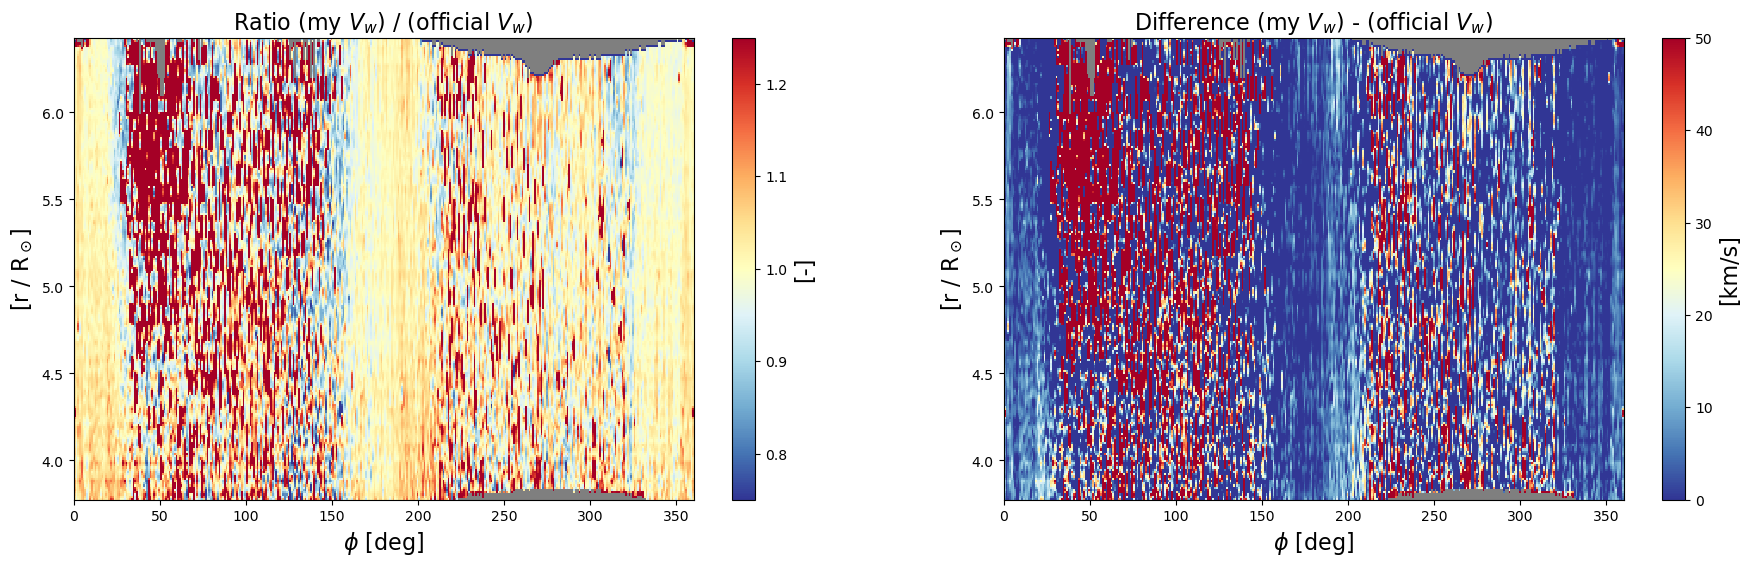

In [53]:
# PLOT

fig2 = plt.figure(figsize=(22, 6))

ax4 = fig2.add_subplot(1, 2, 1)

img_Vw_pol = ax4.imshow(my_Vw_map_resam_II / official_Vw_map_resam, origin='lower', cmap=METIS_UV_CMAP, interpolation='none', vmin = 0.75, vmax = 1.25, extent=[0, polar_ne.shape[1], r_common_Vw[0] , r_common_Vw[-1] ], aspect = 'auto')
ax4.set_ylabel("[r / R$_\\odot$]")
ax4.set_xlabel("$\phi$ [deg]");

my_cbar_Vw = plt.colorbar(img_Vw_pol, ax=ax4, label='[-]')
ax4.set_title('Ratio (my $V_w$) / (official $V_w$)');


ax5 = fig2.add_subplot(1, 2, 2)

img_Vw_pol = ax5.imshow(my_Vw_map_resam_II - official_Vw_map_resam, origin='lower', cmap=METIS_UV_CMAP, interpolation='none', vmin = 0, vmax = 50, extent=[0, polar_ne.shape[1], r_common_Vw[0] , r_common_Vw[-1] ], aspect = 'auto')
ax5.set_ylabel("[r / R$_\\odot$]")
ax5.set_xlabel("$\phi$ [deg]");

my_cbar_Vw = plt.colorbar(img_Vw_pol, ax=ax5, label='[km/s]')
ax5.set_title('Difference (my $V_w$) - (official $V_w$)');

print(f"Average value of the ratio map: {np.nanmean(1/(my_Vw_map_resam_II / official_Vw_map_resam)):.2f}")
print(f"Average value of the difference map: {np.nanmean((my_Vw_map_resam_II - official_Vw_map_resam)):.2f} km/s")